# Surface Plasmon Resonance with PyMoosh

In this notebook, we will explore how PyMoosh allows to simulate and understand surface plasmon resonance in the case of a prism coupler. You can do actual research with an apparently so simple program. See [this paper](https://www.dropbox.com/s/r6b2zv2bprzueou/PhysRevA.94.063808.pdf?dl=0). You'll recognize the plots.

First a little background. The surface plasmon is a guided mode along the interface between a metal and a dielectric. Its dispersion relation is analytic, and is given by 
\begin{equation}
 k _x = k_0 \sqrt{\frac{\epsilon_m \epsilon_d}{\epsilon_m + \epsilon_d}}
\end{equation}


## Otto configuration

We first consider the excitation of a surface plasmon using the Otto configuration, which is historically the first one to have been experimentally achieved. 

In [102]:
from PyMoosh import *
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

wavelength = 600
size_gold = 100
perm_prism = 1.7**2
otto = Structure([1.,'Gold','Water',1.46**2,perm_prism],[4,0,1],[10,200,size_gold])

List of materials:
Simple, non dispersive: epsilon= (1+0j)
Database material: BrendelBormann model: Gold
Database material: ExpData: Water
Simple, non dispersive: epsilon= (2.1315999999999997+0j)
Simple, non dispersive: epsilon= (2.8899999999999997+0j)


We can, thanks to the formula above, compute the effective index of the surface plasmon, $n_\text{eff} = \frac{k_x}{k_0}$ and then the corresponding incidence angle $\theta$, using the formula $$ n \sin \theta = n_\text{eff},$$ 

where $n = 1.7$. This means that the evanescent wave generate by the prism will have the same periodicitiy along the interface as the surface plasmon, allowing for it to be excited. 

In [103]:
epsilon_m = otto.materials[1].get_permittivity(600)
n_eff =  np.sqrt(epsilon_m /(1+epsilon_m)) 
print(n_eff)
print(asin(np.real(n_eff)/1.7)/np.pi*180)

(1.0629502930881012+0.011545733508350298j)
38.701631456872285


Now we plot the reflectance of the structure and can see that there is actually a dip in the reflectance right at the computed angle. This is the surface plasmon, which, when excited, leads to a lot of losses in the structure.

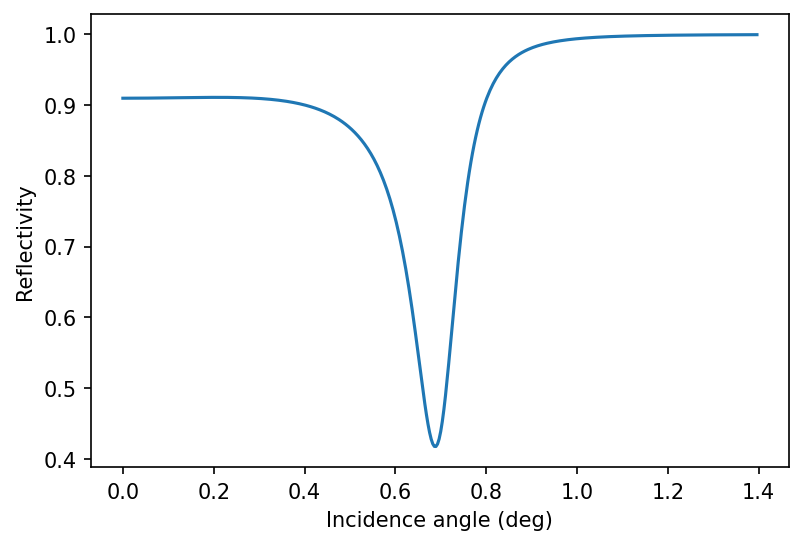

In [104]:
wavelength = 600
incidence,r,t,R,T=angular(otto,wavelength,1.,0.,80.,400)
plt.plot(incidence,R)
plt.xlabel("Incidence angle (deg)")
plt.ylabel("Reflectivity")
plt.show()


Pixels horizontally: 75
Incidence in degrees: 38.7
H//, TM, p polarization
Pixels vertically: 24


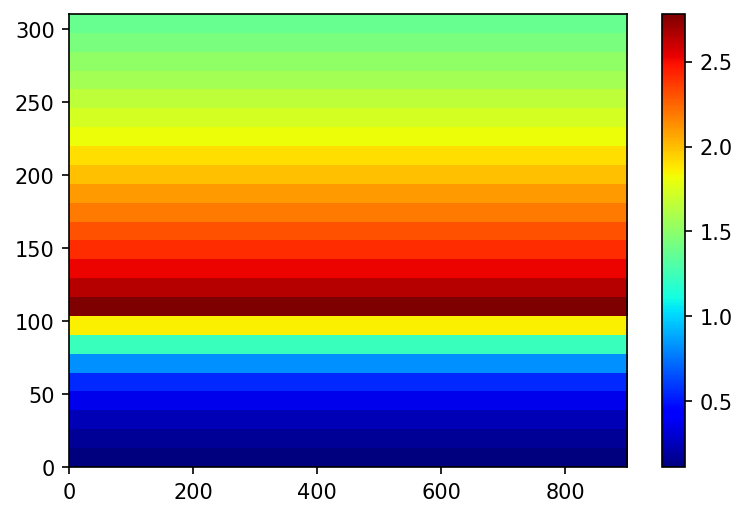

In [105]:
window = Window(1.5*wavelength,0.4,wavelength/50.1,wavelength/50.1)
beam = Beam(wavelength,38.7/180*np.pi,1,10*wavelength)
E=field(otto,beam,window)
plt.figure(2)
plt.imshow(abs(E),cmap='jet',extent=[0,window.width,0,sum(otto.thickness)],aspect='auto')
plt.colorbar()

Pixels vertically: 24


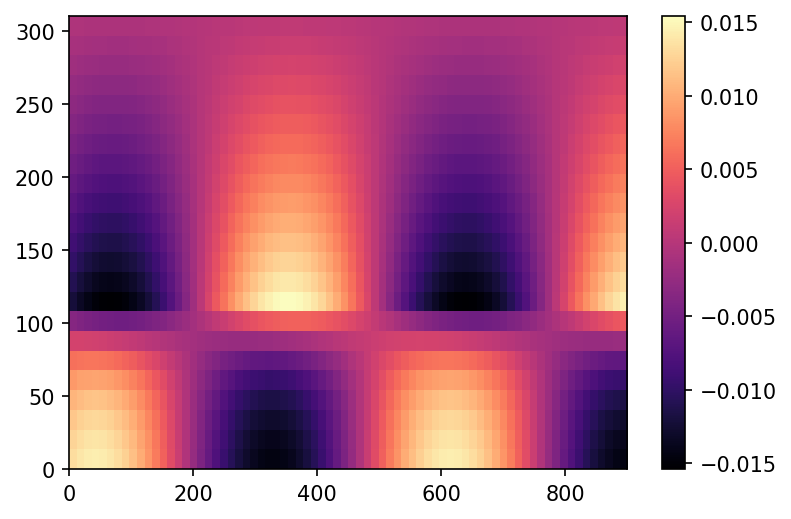

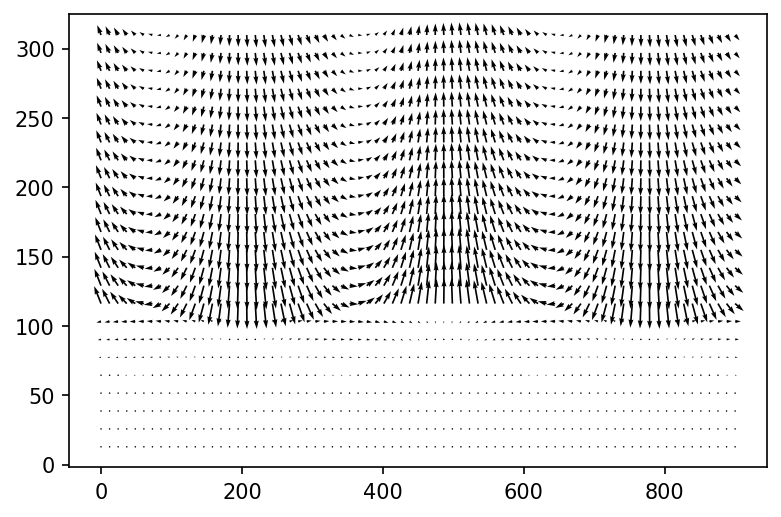

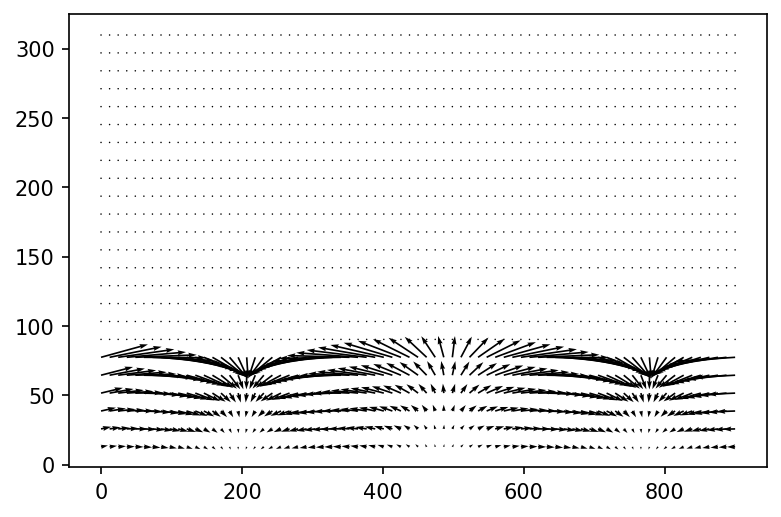

In [106]:

H, Ex, Ez = fields(otto,beam,window)


dzEx = (Ex[1:] - Ex[:1]) / sum(otto.thickness)
dxEz = (Ez[:,1:] - Ez[:,1:]) / window.width

rot_E = dzEx[:,1:]-dxEz[1:]

plt.imshow(np.real(rot_E), cmap='magma', extent=[0,window.width,0,sum(otto.thickness)], aspect='auto')
plt.colorbar()
plt.show()

ny = int(sum(otto.thickness)/window.py)
positions_x = np.linspace(0, window.width, window.nx)
positions_z = sum(otto.thickness)-np.linspace(0, sum(otto.thickness), ny)
vec_E = []
vec_j = []

susceptibility_metal = (otto.materials[1].get_permittivity(600) - 1)

for i in range(window.nx):
    for j in range(ny-1):
        if sum(otto.thickness) - j * window.py < size_gold :
            jx = np.real(Ex[j,i] * susceptibility_metal)
            jz = np.real(Ez[j,i] * susceptibility_metal)
            vec_E.append([positions_x[i], positions_z[j], np.real(Ex[j,i]), np.real(Ez[j,i])])
            vec_j.append([positions_x[i], positions_z[j], jx, jz])
        else:
            vec_E.append([positions_x[i], positions_z[j], np.real(Ex[j,i]), np.real(Ez[j,i])])
            vec_j.append([positions_x[i], positions_z[j], 0, 0])
vec_E = np.array(vec_E)
vec_j = np.array(vec_j)

plt.quiver(vec_E[:, 0], vec_E[:, 1], vec_E[:, 2], vec_E[:, 3])
plt.show()
plt.quiver(vec_j[:, 0], vec_j[:, 1], vec_j[:, 2], vec_j[:, 3], scale=300.)
plt.show()
# vec_E = np.array()
# X, Y, U, V = zip(*np.array([Ex, Ez]))

# ax = plt.gca()
# ax.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=1)
# plt.draw()

The surface plasmon does not propagate very far, due to losses. But the resonance at the surface of the metallic plane is obvious. The resonance may shift when the prism is closer to the metallic surface because this perturbs the mode.

## Krestschman Raether configuration

The Krestschmann Raether configuration is obtained by interverting metal and air, essentially. The huge advantage is that the 

List of materials:
Simple, non dispersive: epsilon= (1+0j)
Database material: BrendelBormann model: Gold
Database material: ExpData: Water
Simple, non dispersive: epsilon= (2.1315999999999997+0j)
Simple, non dispersive: epsilon= (2.8899999999999997+0j)


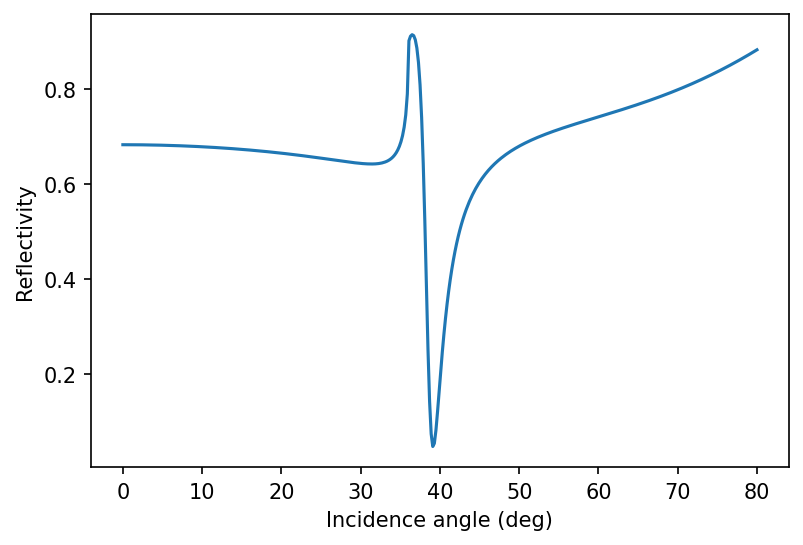

In [12]:
kr = Structure([1.,'Gold','Water',1.46**2,1.7**2],[4,1,0],[500,40,500])
incidence,r,t,R,T=angular(kr,wavelength,1.,0.,80.,400)
plt.plot(incidence,R)
plt.xlabel("Incidence angle (deg)")
plt.ylabel("Reflectivity")
plt.show()


Now it is possible to see that below 35° the gold film being somewhat transparent, the reflection is not that high. Around 35° is the total internal reflection, for $k_x = k_0$. Then, when $k_x = n_\text{eff} k_0$, for a slightly larger incidence angle, a resonance occurs. The surface plasmon is excited through the metal on the metal-air surface. We can have a look at the field map, again.


Pixels horizontally: 8400
Pixels vertically: 208


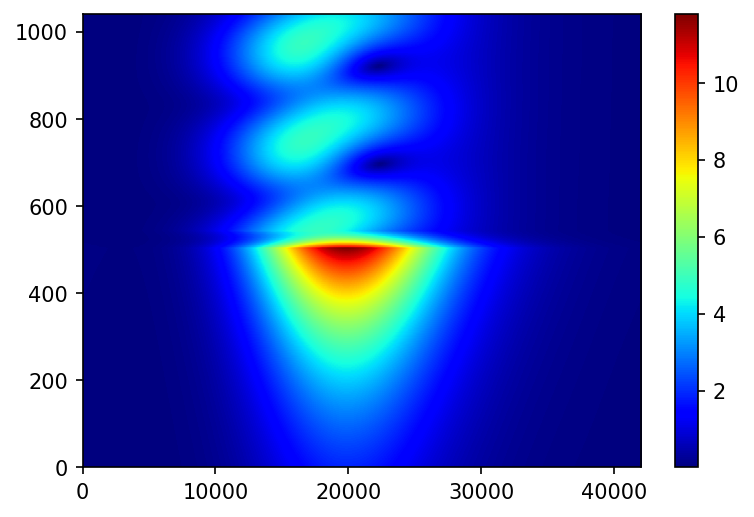

In [13]:
window = Window(70*wavelength,0.4,5.,5.)
E=field(kr,beam,window)
plt.figure(2)
plt.imshow(abs(E),cmap='jet',extent=[0,window.width,0,sum(kr.thickness)],aspect='auto')    
plt.colorbar()

We will now include a thin layer of organic material below the metallic film, and put everything in contact with water. This is what occurs when molecules of interest bind themselves to the gold film (usually functionalized) and form a film with a slightly larger refractive index than water (1.46 instead of 1.33 typically). The surface plasmon resonance will then shift. 

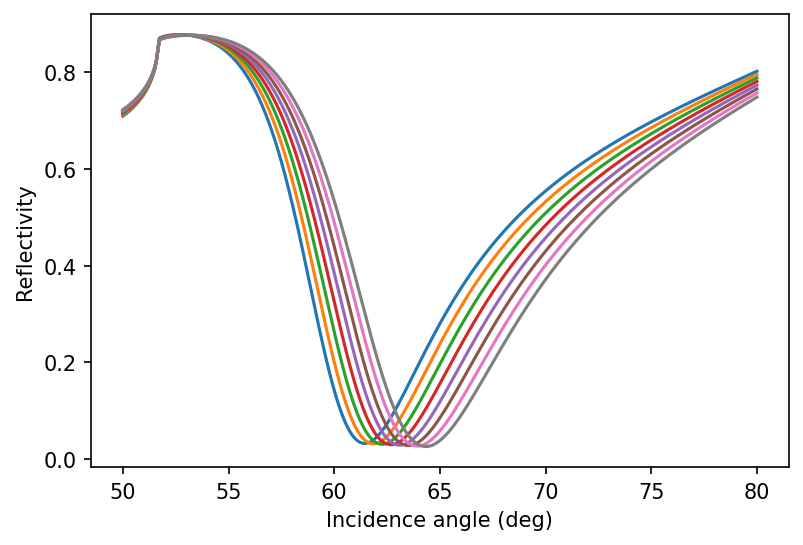

In [14]:
h = np.linspace(0.,20.,8)
for thickness in h :
    kr = Structure([1.,'Gold','Water',1.46**2,1.7**2],[4,1,3,2],[500,40,thickness,500-thickness],verbose = False)
    incidence,r,t,R,T=angular(kr,wavelength,1.,50.,80.,400)
    plt.plot(incidence,R)
plt.xlabel("Incidence angle (deg)")
plt.ylabel("Reflectivity")
plt.show()
